In [23]:
using DataFrames, CSV, FITSIO
using PyCall, PyPlot
using LinearAlgebra

TODO: why doesn't GALAH use every observation?  Should be we stick to spectra with corresponding entries in the catalog? 

In [2]:
galah = DataFrame(CSV.read("GALAH_DR2.1.csv"));
for col in names(galah)
    if Missing <: typeof(galah[1, col])
        galah[!, col][ismissing.(galah[!, col])] .= NaN
    end
end
;
galah.dirname = [s[1:6] for s in string.(galah.sobject_id)];

In [3]:
dirs = by(galah, :dirname, N = :sobject_id=>length)
sort(dirs, :N, rev=true)

,dirname,N
,String,Int64
1,170713,3311
2,170711,3029
3,160522,3003
4,170906,3000
5,160421,2968
6,160327,2925
7,170516,2888
8,170418,2840
9,170515,2839


In [4]:
dir = "170713"

"170713"

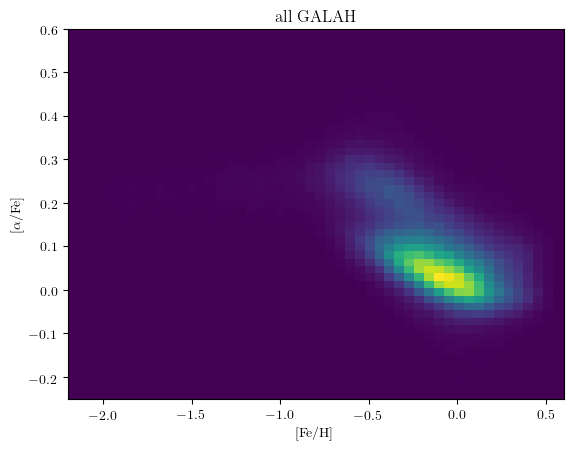

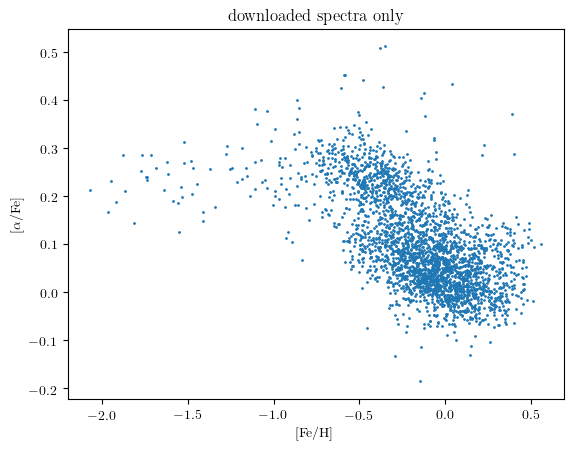

PyObject Text(23.837000138370016, 0.5, '[$\\alpha$/Fe]')

In [5]:
plt.hist2d(galah.fe_h, galah.alpha_fe, bins=50, range=[[-2.2, 0.6],[-0.25,0.6]])
xlabel("[Fe/H]")
ylabel(L"[$\alpha$/Fe]")
title("all GALAH")
figure()
downloaded = startswith.(string.(galah.sobject_id), dir)
title("downloaded spectra only")
scatter(galah.fe_h[downloaded], galah.alpha_fe[downloaded], s=1)
xlabel("[Fe/H]")
ylabel(L"[$\alpha$/Fe]")

In [6]:
downloaded .&= (galah.sobject_id .!= 170713006101002) .& (galah.sobject_id .!= 170713005601193)
subset = galah[downloaded, :];
println("$(sum(downloaded)) stars")

3309 stars


# try model with GALAH spectra

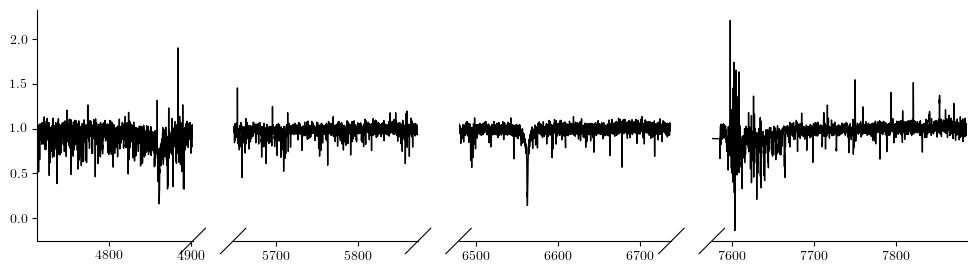

In [18]:
brokenaxes = pyimport("brokenaxes").brokenaxes
include("get_galah_spectra.jl")

wls, fs, errs = load_spectrum(170713005601288)
figure(figsize=(12, 3))
bax = brokenaxes(xlims=((4713, 4902), (5648, 5873), (6479, 6738), (7576, 7887)))
bax.plot(wls, fs, c="k", lw=1)
;

In [19]:
#load spectra
npix, nstars = length(wls), size(subset,1)
F = Matrix(undef, npix, nstars)
S = Matrix(undef, npix, nstars)
for (i, row) in enumerate(eachrow(subset))
    _, flux, err = load_spectrum(row.sobject_id)
    F[:, i] = flux
    S[:, i] = err
end

F = Float32.(F)
S = Float32.(S)

F[F.==0] .= NaN
F .-= 1;
S[S .< 0] .= 100.0
;

In [20]:
Δλ = 0.2 
li_air = 6707.85
li_mask = li_air - Δλ .< wls .< li_air + Δλ
sum(li_mask)

6

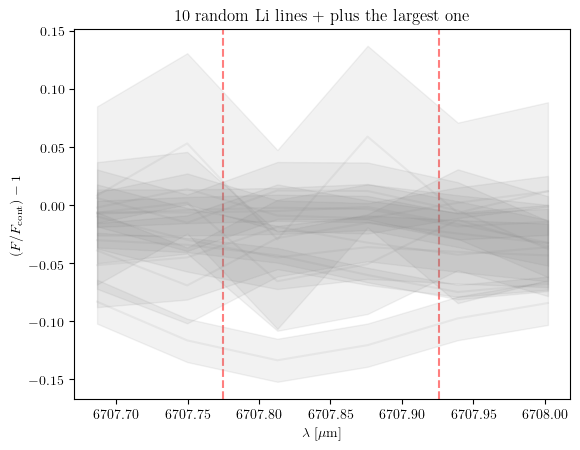

PyObject Text(0.5, 1, '10 random Li lines + plus the largest one')

In [21]:
for j in rand(1:size(F, 2), 10)
    plot(wls[li_mask], F[li_mask, j], color="grey", alpha=0.1)
    fill_between(wls[li_mask], F[li_mask, j] .- S[li_mask, j], F[li_mask, j] .+ S[li_mask, j], color="grey", alpha=0.1)
end
j = 2609
plot(wls[li_mask], F[li_mask, j], color="grey", alpha=0.1)
fill_between(wls[li_mask], F[li_mask, j] .- S[li_mask, j], F[li_mask, j] .+ S[li_mask, j], color="grey", alpha=0.1)

axvline(6707.926, ls="--", c="red", alpha=0.5, zorder=-1)
axvline(6707.775, ls="--", c="red", alpha=0.5, zorder=-1)
ylabel(L"(F/F_\mathrm{cont}) - 1")
xlabel(L"\lambda~\mathrm{[\mu m]}")
title("10 random Li lines + plus the largest one")

# try on a single star

In [22]:
include("model.jl")
K = 15
i = rand(1:nstars)
wlmask = .!li_mask

spectral_dist(f1, s1, f2, s2) = sum(@. (f1-f2)^2/(s1^1 + s2^2))

print("to calculate distances: ")
@time dists = map(1:nstars) do j
    spectral_dist(F[wlmask, i], S[wlmask, i], F[wlmask, j], S[wlmask, j])
end

print("to sort: ")
@time perm = sortperm(dists)
neighbors = perm[2:K+1]

print("to calculate weights: ")
w = calculate_weights(F[wlmask, neighbors], S[wlmask, neighbors], F[wlmask, i], S[wlmask, i])

figure(figsize=(12, 3))
plot(wls[wlmask], F[wlmask, i], label="data", c="k")
plot(wls[wlmask], F[wlmask, neighbors]*w, label="best-fit model", alpha=0.6)
title("training region")
ylabel(L"(F/F_\mathrm{cont}) - 1")
xlabel(L"\lambda~\mathrm{[\mu m]}")
ylim(-0.5, 0.2)

figure(figsize=(12, 3))
plot(wls[li_mask], F[li_mask, i], label="data", c="k")
fill_between(wls[li_mask], F[li_mask, i] .- S[li_mask, i], F[li_mask, i] .+ S[li_mask, i], color="grey", alpha=0.6)
plot(wls[li_mask], F[li_mask, neighbors]*w, label="best-fit model", alpha=0.7)
axvline(6707.926, ls="--", c="red", alpha=0.5, zorder=-1)
axvline(6707.775, ls="--", c="red", alpha=0.5, zorder=-1)
title("censored region")
ylabel(L"(F/F_\mathrm{cont}) - 1")
xlabel(L"\lambda~\mathrm{[\mu m]}")
ylim(-0.2, 0.1)

to calculate distances:   1.972976 seconds (1.34 M allocations: 1.073 GiB, 45.45% gc time)
to sort:   0.137085 seconds (306.03 k allocations: 15.100 MiB)
to calculate weights: 

UndefVarError: UndefVarError: Diag not defined

In [12]:
bar(1:length(w), sort(abs.(w), rev=true), tick_label=[latexstring("w_{$i}") for i in 1:length(w)])
ylabel(L"|w|")

UndefVarError: UndefVarError: w not defined

In [13]:
include("model.jl")
K = 15
EWs = map(1:100) do i
    wlmask = .!li_mask

    spectral_dist(f1, s1, f2, s2) = sum(@. (f1-f2)^2/(s1^1 + s2^2))

    dists = map(1:nstars) do j
        spectral_dist(F[wlmask, i], S[wlmask, i], F[wlmask, j], S[wlmask, j])
    end
    neighbors = perm[2:K+1]

    print("to calculate weights: ")
    w = calculate_weights(F[wlmask, neighbors], S[wlmask, neighbors], F[wlmask, i], S[wlmask, i])
    sum((F[li_mask, neighbors] * w - F[li_mask, i])./sqrt.(S[li_mask, i].^2 .+ transpose(S[li_mask, neighbors])*Diag(w)*S[li_mask, neighbors]))
end
;

UndefVarError: UndefVarError: li_mask not defined

In [14]:
scatter(1:100, EWs)

UndefVarError: UndefVarError: EWs not defined

In [15]:
i = argmin(EWs)
w = calculate_weights(F[wlmask, neighbors], S[wlmask, neighbors], F[wlmask, i], S[wlmask, i])
plot(wls[li_mask], F[li_mask, neighbors]*w)
plot(wls[li_mask], F[li_mask, i])

UndefVarError: UndefVarError: EWs not defined

In [16]:
plot(F[:, 72])

UndefVarError: UndefVarError: F not defined